# Transfer learning в решении задачи классификации цветов
Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:
<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

In [1]:
!pip install tensorflow==2.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
#from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
#from tf.keras.applications.inception_v3 import Inception_v3

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['flower-dataset-102']
Python       : 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
Numpy        : 1.18.2
Tensorflow   : 2.1.0
Keras        : 2.2.4-tf


In [3]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

Работаем уже с Tensorflow 2.1 но для воспроизводимости сохраним версии всех пакетов

In [4]:
!pip freeze > requirements.txt

# Setup

In [5]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 25
BATCH_SIZE           = 128
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 128
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/flower-dataset-102/'
PATH = "../working/flower/"

In [6]:
# Setting seed for reproducibility
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Data

In [7]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [8]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [9]:
df['Category'].value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
2      40
0      40
20     40
44     40
33     40
Name: Category, Length: 102, dtype: int64

In [10]:
df['Category'].nunique()

102

In [11]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(PATH)

print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_04929.jpg', 'image_05141.jpg', 'image_00792.jpg', 'image_06482.jpg', 'image_07418.jpg']


Пример картинок (random sample)


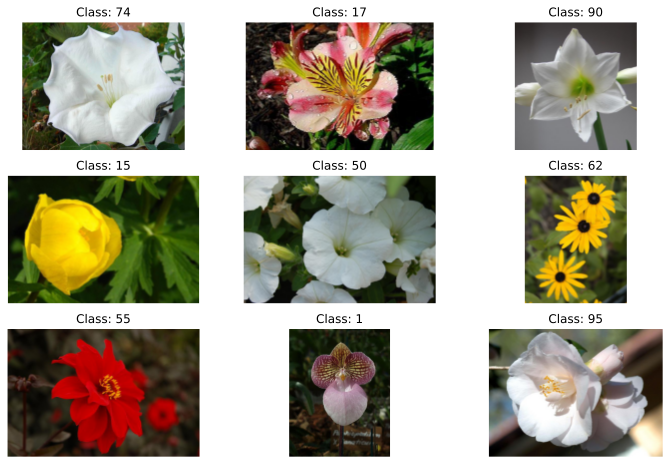

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


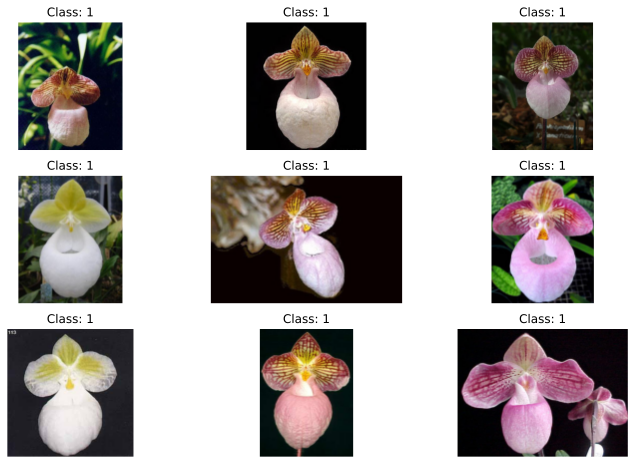

In [13]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

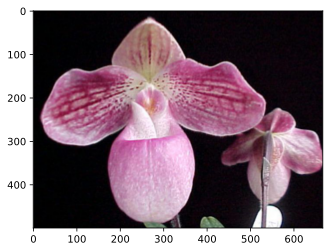

(667, 500)

In [14]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

 ## Stratify Split

In [15]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [16]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [17]:
train_files['Category'].value_counts()

50    206
76    201
45    157
72    155
88    147
     ... 
26     32
20     32
44     32
33     32
6      32
Name: Category, Length: 102, dtype: int64

In [18]:
test_files['Category'].value_counts()

50    52
76    50
72    39
45    39
88    37
      ..
0      8
78     8
25     8
66     8
6      8
Name: Category, Length: 102, dtype: int64

### Data augmentation

In [19]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [20]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из train_generator


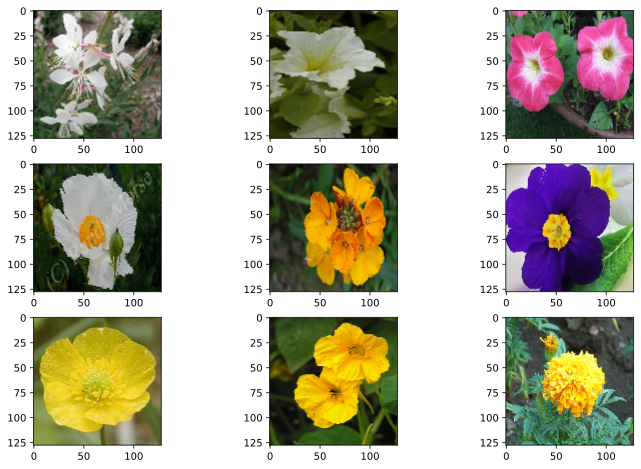

In [21]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


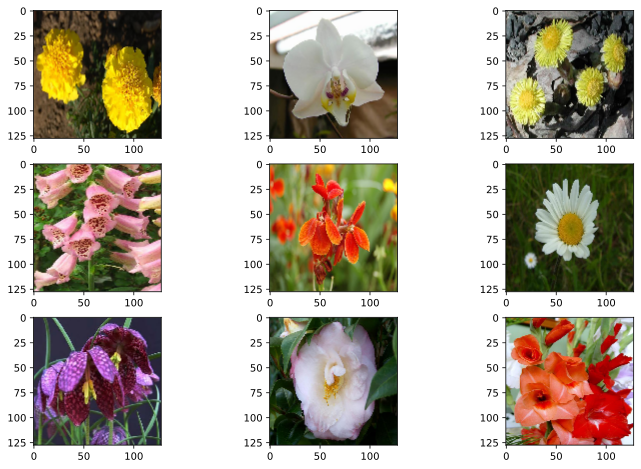

In [22]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [23]:
input_shape

(128, 128, 3)

In [24]:
model = M.Sequential()

# model layer 1
model.add(L.Convolution2D(128, (3, 3), input_shape=input_shape, activation='relu', padding='same',))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(128, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())

# Pooling layer 1
model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.2))

# model and pooling layer 2
model.add(L.Convolution2D(256, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(256, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())

model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.3))

# model and pooling layer 3.
model.add(L.Convolution2D(512, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())
model.add(L.Convolution2D(512, (3, 3), activation='relu', padding='same',))
model.add(L.BatchNormalization())

model.add(L.MaxPooling2D(pool_size=(2,2)))
model.add(L.Dropout(0.3))


# Flattening
model.add(L.Flatten())

# Full connection
model.add(L.Dense(512, activation='relu'))
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       2

In [26]:
# сколько слоев
print(len(model.layers))

22


In [27]:
len(model.trainable_variables)

28

## Fit

In [28]:
#LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [29]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [30]:
scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 6s 6s/step - loss: 4.6262 - accuracy: 0.0000e+00
Accuracy: 0.00%


In [31]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Train for 51 steps, validate for 12 steps
Epoch 1/25
50/51 [============================>.] - ETA: 0s - loss: 13.9438 - accuracy: 0.0300
Epoch 00001: saving model to best_model.hdf5
51/51 [==============================] - 59s 1s/step - loss: 13.7685 - accuracy: 0.0299 - val_loss: 25.5247 - val_accuracy: 0.0202
Epoch 2/25
50/51 [============================>.] - ETA: 0s - loss: 4.9450 - accuracy: 0.0397
Epoch 00002: saving model to best_model.hdf5
51/51 [==============================] - 56s 1s/step - loss: 4.9466 - accuracy: 0.0395 - val_loss: 9.3438 - val_accuracy: 0.0273
Epoch 3/25
50/51 [============================>.] - ETA: 0s - loss: 4.5914 - accuracy: 0.0545
Epoch 00003: saving model to best_model.hdf5
51/51 [==============================] - 56s 1s/step - loss: 4.5884 - accuracy: 0.0543 - val_loss: 5.6814 - val_accuracy: 0.0306
Epoch 4/25
50/51 [============================>.] - ETA: 0s - loss: 4.4204 - accuracy: 0.0766
Epoch 00004: saving model to best_model.hdf5
51/51 [=====

In [32]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [33]:
scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 1s 885ms/step - loss: 4.1457 - accuracy: 0.2891
Accuracy: 28.91%


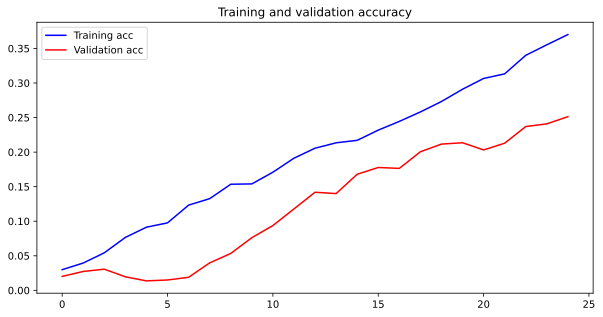

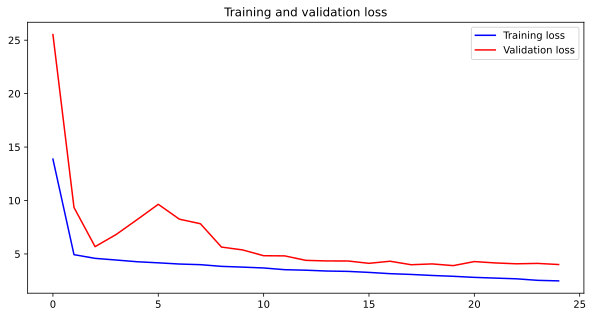

In [34]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

In [35]:
# Clean PATH
import shutil
shutil.rmtree(PATH)